## Caption Detector Usage

In [1]:
import pandas as pd
from util import *
from caption_extraction import *

In [2]:
# pdfplumber로 추출한 image, table, text 정보
samsung_image = pd.read_pickle('data/[삼성전자]사업보고서(2022.03.08)_image.pickle')
samsung_table = pd.read_pickle('data/[삼성전자]사업보고서(2022.03.08)_table.pickle')
samsung_text = pd.read_pickle('data/[삼성전자]사업보고서(2022.03.08)_text.pickle')

# 공시문서 pdf 원본의 경로
path = 'data/[삼성전자]사업보고서(2022.03.08).pdf'
pages = get_pages(get_pdf(path))

In [4]:
# 특정 페이지 체크용
checks = [551]
for check in checks:
    caption_detector(pages, samsung_image, samsung_table, samsung_text, corp='[삼성전자]사업보고서(2022.03.08)', check=check)

  0%|          | 0/569 [00:00<?, ?it/s]

In [3]:
# 모든 페이지에 대한 결과를 이미지 파일로 저장
caption_detector(pages, samsung_image, samsung_table, samsung_text, corp='[삼성전자]사업보고서(2022.03.08)', resolution=200)

  0%|          | 0/569 [00:00<?, ?it/s]

## Visualization for Check

In [38]:
# 저장되는 이미지 파일 이름과 같은 값으로
p = 550
p -= 1

for idx, text in enumerate(samsung_text[p]):
    if '※' in text['text']: # ※☞
        print(idx)

388
391
402
416
420
449


table: (50.0, 50.0, 545.0, 418.0)
text: (52.0, 425.997, 59.0, 432.997)
text: (52.0, 441.997, 59.0, 448.997)
difference of height: 9.0


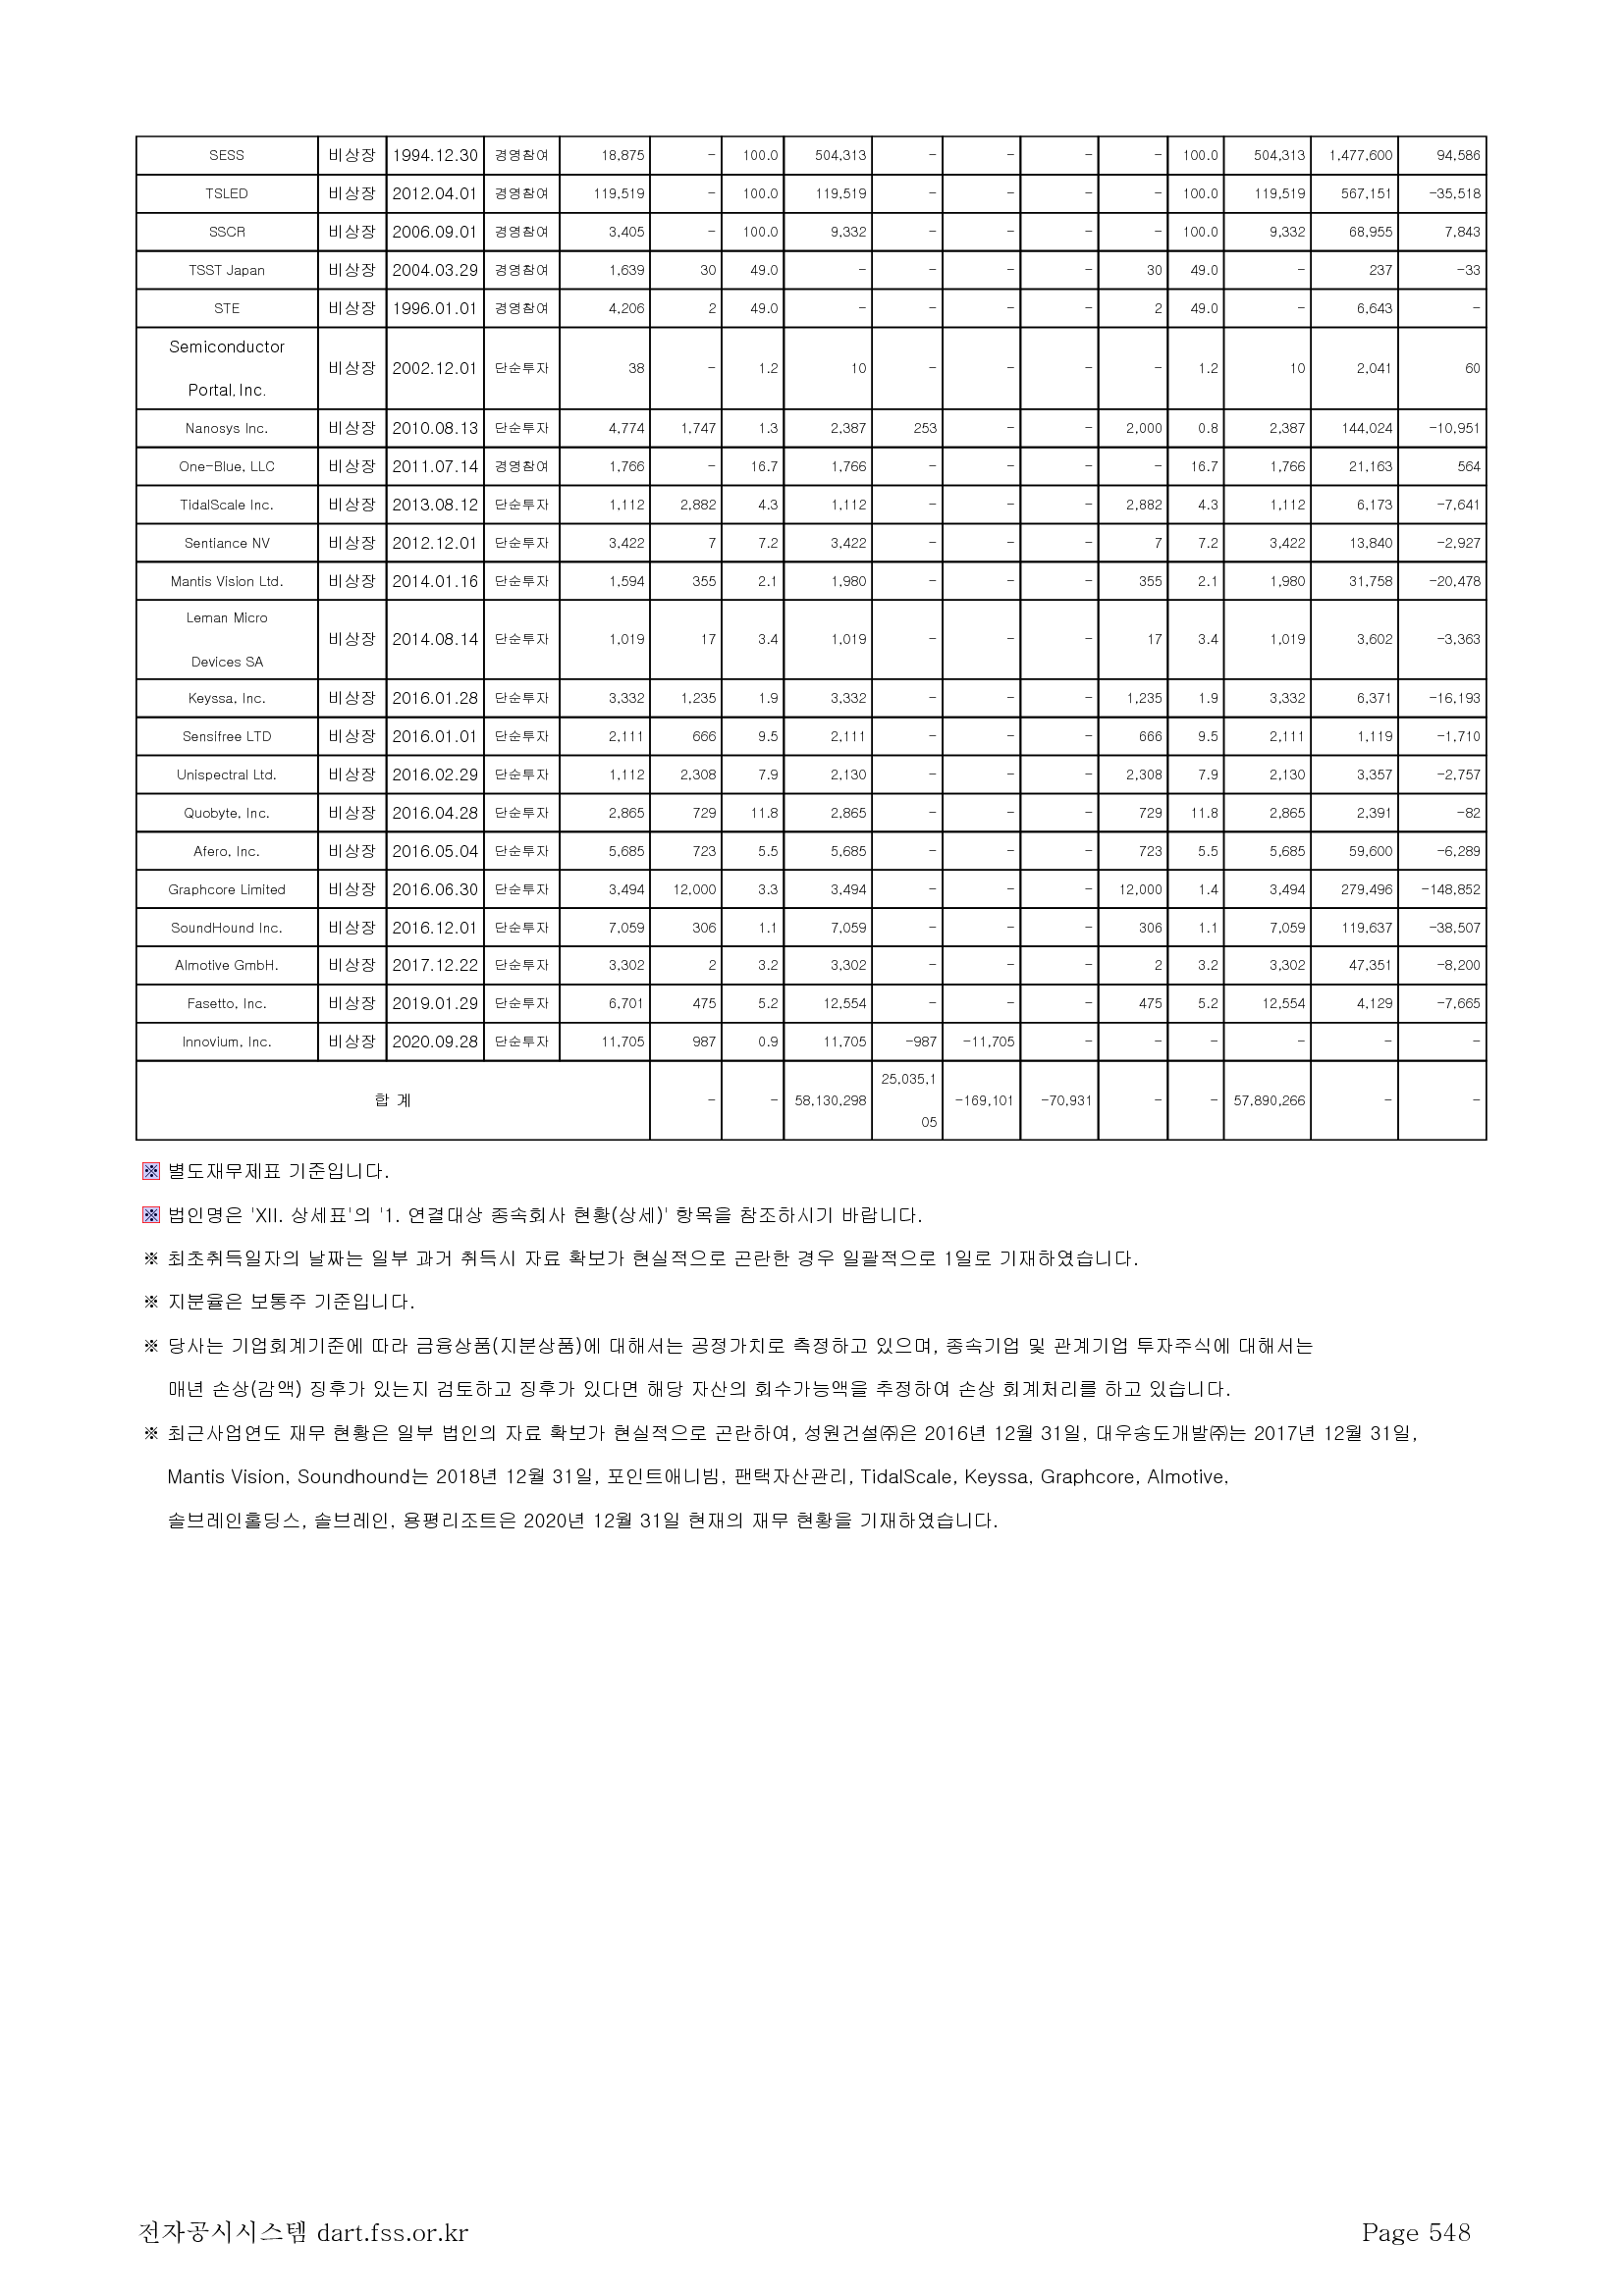

In [39]:
# 저장되는 이미지 파일 이름과 같은 값으로
p = 550
p -= 1

i = 0 # table
j = 388 # text1
k = 391 # text2

table_list = [table['bbox'] for table in samsung_table[p]]
# text_list = [(round(text['x0'], 2), round(text['top'], 2), round(text['x1'], 2), round(text['bottom'], 2)) for text in samsung_text[p]]
text_list = [(text['x0'], text['top'], text['x1'], text['bottom']) for text in samsung_text[p]]

print('table:', table_list[i])
print('text:', text_list[j])
print('text:', text_list[k])
# print('distance:', round(rect_distance(table_list[i], text_list[j]), 2))
# print('distance:', round(rect_distance(text_list[j], text_list[k]), 2))
print('difference of height:', diff_height(text_list[j], text_list[k]))
# print(round(text_list[j][1], 2) == round(text_list[k][1], 2))
# print(round(text_list[j][3], 2) == round(text_list[k][3], 2))
# print(contains(table_list[i], text_list[j]))

im = pages[p].to_image(resolution=200)
im.reset()
# im.draw_rect(table_list[i])
im.draw_rect(text_list[j])
im.draw_rect(text_list[k])